In [339]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Conv2D, Conv1D, MaxPooling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow import keras, config
import numpy as np
import matplotlib.pyplot as plt

In [340]:
print("GPUs Available: ", len(config.list_physical_devices('GPU')))

GPUs Available:  1


In [341]:
# Global settings
IMAGE_TARGET_SIZE = (5, 1400, 1)
BATCH_SIZE =  32

In [342]:

%load_ext autoreload
%autoreload 2

from morse_helpers import create_sets
from morse_label_funcs import  labels_to_one_hot_positions_categorical, letter_n_to_one_hot_positions_categorical, position_regression

(image_fnames, morse_labels) = create_sets(
    [
        ["./training_data/MorseTrainSet_04/GEN04_VER_000/", 'wordsMatrices_04_000', "Words_04_000.csv"],
        # ["./training_data/MorseTrainSet_04/GEN04_VER_100/", 'wordsMatrices_04_100', "Words_04_100.csv"],
        # ["./training_data/MorseTrainSet_04/GEN04_VER_200/", 'wordsMatrices_04_200', "Words_04_200.csv"],
        # ["./training_data/MorseTrainSet_04/GEN04_VER_210/", 'wordsMatrices_04_210', "Words_04_210.csv"],
        # ["./training_data/MorseTrainSet_04/GEN04_VER_220/", 'wordsMatrices_04_220', "Words_04_220.csv"],

        # ["./training_data/MorseTrainSet_11/GEN11_VER_000/", 'wordsMatrices_11_000', "Words_11_000.csv"],
        # ["./training_data/MorseTrainSet_11/GEN11_VER_100/", 'wordsMatrices_11_100', "Words_11_100.csv"],
        # ["./training_data/MorseTrainSet_11/GEN11_VER_200/", 'wordsMatrices_11_200', "Words_11_200.csv"],
        # ["./training_data/MorseTrainSet_11/GEN11_VER_210/", 'wordsMatrices_11_210', "Words_11_210.csv"],
        # ["./training_data/MorseTrainSet_11/GEN11_VER_220/", 'wordsMatrices_11_220', "Words_11_220.csv"],

    ], 
    IMAGE_TARGET_SIZE,
    [position_regression, letter_n_to_one_hot_positions_categorical],
    letter_n=1
)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1400
1
['a' 'ab' 'aback' ... 'portables' 'portals' 'porte']


In [343]:
# n = 10
# image_fnames[n], morse_labels, morse_labels[0][n] * 1400

In [344]:

morse_labels = np.array([morse_labels[0], morse_labels[1]]).T

# morse_labels = morse_labels[0]

morse_labels[0]



array([0.02928571, 1.        ])

In [345]:

def labels_to_one_hot(train_images, lbls, image_target_size = None):
    labelsints = lbls.astype("int")
    labels_one_hot = np.zeros((labelsints.size, 27))
    labels_one_hot[np.arange(labelsints.size),labelsints] = 1
    return (train_images, labels_one_hot)


In [346]:
from morse_helpers import create_all_sets

TEST_SPLIT_SIZE = 0.90
VALIDATION_SPLIT_SIZE = 0.90

train, labels, train_validation, labels_validation, train_test, labels_test = create_all_sets(
    image_fnames, morse_labels, TEST_SPLIT_SIZE, VALIDATION_SPLIT_SIZE, shuffle_before_test_split=True)



In [347]:
from morse_helpers import Image_Generator, zeropad_randomly

training_batch_generator = Image_Generator(train, labels[:, 0], BATCH_SIZE, IMAGE_TARGET_SIZE, [zeropad_randomly])
validation_batch_generator = Image_Generator(train_validation, labels_validation[:, 0], BATCH_SIZE, IMAGE_TARGET_SIZE, [zeropad_randomly])
test_batch_generator = Image_Generator(train_test, labels_test[:, 0], BATCH_SIZE, IMAGE_TARGET_SIZE, [])


# ts, ls = training_batch_generator.__getitem__(0)

# ls[0]


In [348]:
training_batch_generator_letter = Image_Generator(train, labels[:, 1], BATCH_SIZE, IMAGE_TARGET_SIZE, [labels_to_one_hot])
validation_batch_generator_letter = Image_Generator(train_validation, labels_validation[:, 1] , BATCH_SIZE, IMAGE_TARGET_SIZE, [labels_to_one_hot])
test_batch_generator_letter = Image_Generator(train_test, labels_test[:, 1] , BATCH_SIZE, IMAGE_TARGET_SIZE, [labels_to_one_hot])


# ts, ls = training_batch_generator_letter.__getitem__(0)


# # fig = plt.figure(figsize=(30,5))
# # plt.xlim(0, 400)
# # plt.imshow(ts[0])

# # ts[0], ls[0]


# ls.shape

# training_batch_generator_letter.next()

In [369]:
class MultipleInputGenerator(keras.utils.Sequence):
    """Wrapper of 2 ImageDataGenerator"""

    def __init__(self, gen1, gen2):

        # Real time multiple input data augmentation
        self.gen1 = gen1
        self.gen2 = gen2

    def __len__(self):
        """It is mandatory to implement it on Keras Sequence"""
        return self.gen1.__len__()

    def __getitem__(self, index):
        """Getting items from the 2 generators and packing them"""
        X1_batch, Y1_batch = self.gen1.__getitem__(index)
        X2_batch, Y2_batch = self.gen2.__getitem__(index)

        X_batch = (X1_batch, X2_batch)
        Y_batch = (Y1_batch, Y2_batch)

        return X_batch, Y_batch

gen1 = MultipleInputGenerator(training_batch_generator, training_batch_generator_letter)
gen2 = MultipleInputGenerator(validation_batch_generator, validation_batch_generator_letter)
gen3 = MultipleInputGenerator(test_batch_generator, test_batch_generator_letter)


# gt1, gl1  = gen1.__getitem__(0)

# fig = plt.figure(figsize=(30,5))
# plt.xlim(0, 400)
# plt.imshow(gt1[0][4])


# gl1[0][4] * 1400



In [350]:
# t, l = training_batch_generator.__getitem__(0)

# for i in range(10):
#     print(l[i] * 1400)
#     fig = plt.figure(figsize=(30,5))
#     plt.xlim(0, 800)
#     rolled = np.pad(t[i], [(0,0),(0,0), (0,0)], mode='constant')[:, 0:-1]
#     rolled[:, int(l[i] * 1400)] = 1
#     plt.imshow(rolled)
#     plt.show()

In [370]:
def conv_model(input_layer):
    cropped = keras.layers.Cropping2D(cropping=((0, 0), (0,1000)), data_format=None)(input_layer)
    pool           = MaxPooling2D(pool_size=(2,2),padding="same")(cropped)

    conv1           = Conv2D(80,(3,5),padding="same",activation="relu")(pool)
    pool1           = MaxPooling2D(pool_size=(2,2),padding="same")(conv1)

    conv2           = Conv2D(80,(1,7),padding="same",activation="relu")(pool1)
    pool2           = MaxPooling2D(pool_size=(1,2),padding="same")(conv2)

    conv3           = Conv2D(80,(1,11),padding="same",activation="relu")(pool2)
    pool3           = MaxPooling2D(pool_size=(1,2),padding="same")(conv3)

    conv4           = Conv2D(80,(1,13),padding="same",activation="relu")(pool3)
    pool4           = MaxPooling2D(pool_size=(1,2),padding="same")(conv4)

    conv5           = Conv2D(80,(1,11),padding="same",activation="relu")(pool4)
    pool5           = MaxPooling2D(pool_size=(1,2),padding="same")(conv5)

    conv6           = Conv2D(80,(1,9),padding="same",activation="relu")(pool5)
    pool6           = MaxPooling2D(pool_size=(1,2),padding="same")(conv6)

    conv7           = Conv2D(80,(1,5),padding="same",activation="relu")(pool6)
    pool7           = MaxPooling2D(pool_size=(1,2),padding="same")(conv7)

    flat            = Flatten()(pool7)

    return flat

In [393]:
from tensorflow.keras import layers

input_layer_position     = Input(shape=IMAGE_TARGET_SIZE, name="position")
input_layer_letter     = Input(shape=IMAGE_TARGET_SIZE, name="letter")

flat_position = conv_model(input_layer_position)
flat_letter = conv_model(input_layer_letter)

# x = layers.concatenate([flat_position, flat_letter])

output_layer_position    = Dense(1, name="reg")(flat_position)
output_layer_letter    = Dense(27, activation="softmax", name="cat")(flat_letter)
model           = Model(inputs=[input_layer_position, input_layer_letter], outputs=[output_layer_position, output_layer_letter])
print(model.summary())
model.compile(loss={
        "reg": "mse",
        "cat": keras.losses.CategoricalCrossentropy(),
    }, optimizer='adam', metrics={
        "reg" : "mean_absolute_error", 
        "cat" : keras.metrics.CategoricalCrossentropy()
    })


init_epoch = 0

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
position (InputLayer)           [(None, 5, 1400, 1)] 0                                            
__________________________________________________________________________________________________
letter (InputLayer)             [(None, 5, 1400, 1)] 0                                            
__________________________________________________________________________________________________
cropping2d_44 (Cropping2D)      (None, 5, 400, 1)    0           position[0][0]                   
__________________________________________________________________________________________________
cropping2d_45 (Cropping2D)      (None, 5, 400, 1)    0           letter[0][0]                     
___________________________________________________________________________________________

In [394]:

NUM_EPOCHS = 5

def fit_model(epochs):
	
	global init_epoch
	history = model.fit(
					   gen1,
	                   steps_per_epoch = int(len(train) // BATCH_SIZE),
	                   epochs = epochs + init_epoch,
					   initial_epoch=init_epoch,
	                   verbose =1,
	                   validation_data = gen2,
	                   validation_steps = int(len(train_validation) // BATCH_SIZE))
	
	
	init_epoch += epochs
	return history

history = fit_model(NUM_EPOCHS)


Epoch 1/5
506/506 [==============================] - 16s 31ms/step - loss: 1.1348 - reg_loss: 8.7920e-05 - cat_loss: 1.1347 - reg_mean_absolute_error: 0.0056 - cat_categorical_crossentropy: 1.1347 - val_loss: 0.0031 - val_reg_loss: 3.4741e-06 - val_cat_loss: 0.0031 - val_reg_mean_absolute_error: 0.0015 - val_cat_categorical_crossentropy: 0.0031
Epoch 2/5
506/506 [==============================] - 15s 29ms/step - loss: 0.0056 - reg_loss: 3.1163e-06 - cat_loss: 0.0056 - reg_mean_absolute_error: 0.0011 - cat_categorical_crossentropy: 0.0056 - val_loss: 3.8157e-04 - val_reg_loss: 5.7403e-07 - val_cat_loss: 3.8100e-04 - val_reg_mean_absolute_error: 5.1704e-04 - val_cat_categorical_crossentropy: 3.8100e-04
Epoch 3/5
506/506 [==============================] - 15s 30ms/step - loss: 0.0070 - reg_loss: 1.3585e-06 - cat_loss: 0.0070 - reg_mean_absolute_error: 8.0693e-04 - cat_categorical_crossentropy: 0.0070 - val_loss: 1.8602e-05 - val_reg_loss: 3.2170e-07 - val_cat_loss: 1.8281e-05 - val_reg_me

In [406]:
predictions = model.predict(gen3)

evaluations = model.evaluate(gen3)


evaluations

63/63 [==============================] - 1s 12ms/step - loss: 2.6282e-06 - reg_loss: 1.3010e-07 - cat_loss: 2.4981e-06 - reg_mean_absolute_error: 2.7474e-04 - cat_categorical_crossentropy: 2.4981e-06


[2.6282220915163634e-06,
 1.3010283339554007e-07,
 2.4981186470540706e-06,
 0.0002747449034359306,
 2.4981186470540706e-06]

In [407]:
def show_image(img):
    fig = plt.figure(figsize=(30,5))
    plt.xlim(0, 400)
    plt.imshow(img)
    plt.show()
    return fig

In [408]:
predictions[0][0]

array([0.03217136], dtype=float32)

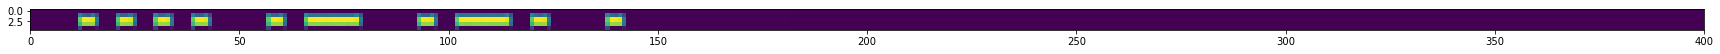

(8, 43.35625767707825)

In [409]:


ts, ls = gen3.__getitem__(0)

item = 5


ts[0][0].shape

show_image(ts[0][item])

np.argmax(predictions[1][item]), predictions[0][item][0] * 1400


In [414]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)

def get_deviating_predictions(above_pixels):
    regression_differences = []
    indexer = 0

    for imgs_batch, labels_batch in test_batch_generator:

        for i in range(len(imgs_batch)):

            pred = predictions[0][indexer] * IMAGE_TARGET_SIZE[1]
            test_label = labels_batch[i] * IMAGE_TARGET_SIZE[1]

            if abs(pred - test_label) > above_pixels:
                regression_differences.append([pred, test_label, imgs_batch[i]])

            indexer += 1

    return regression_differences

above_pixels = 2

deviating_predictions = get_deviating_predictions(above_pixels=above_pixels)

print("Total predictions", len(predictions))
print("Total predictions off by more than pixels", above_pixels, " : ", len(deviating_predictions))
print("Percentage incorrect", round( (len(deviating_predictions) / len(predictions) * 100), 2), "%")

Total predictions 2
Total predictions off by more than pixels 1  :  96
Percentage incorrect 4800.0 %


Prediction [69.104034]


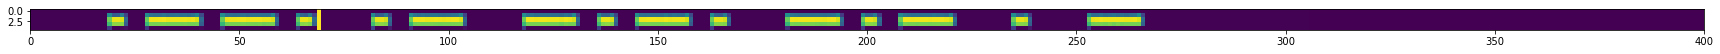

Correct 68.0


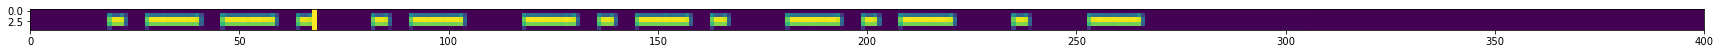

----------------------------------------------------------------------------------------
Prediction [31.383759]


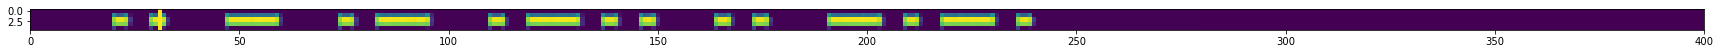

Correct 33.0


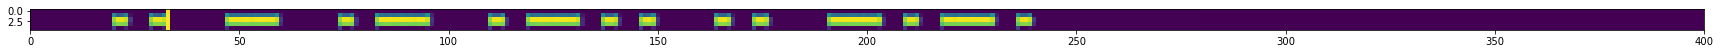

----------------------------------------------------------------------------------------
Prediction [24.601505]


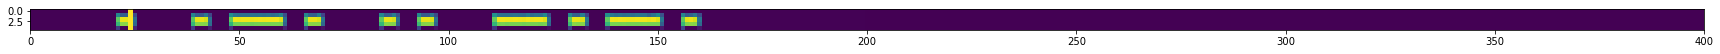

Correct 26.0


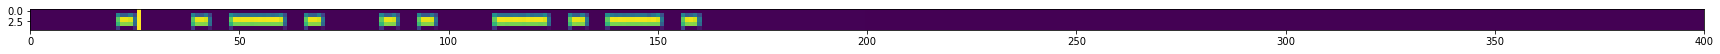

----------------------------------------------------------------------------------------
Prediction [18.887613]


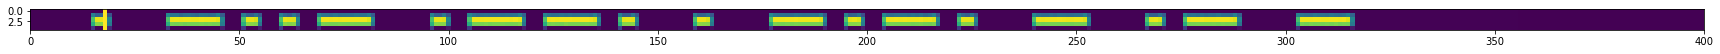

Correct 20.0


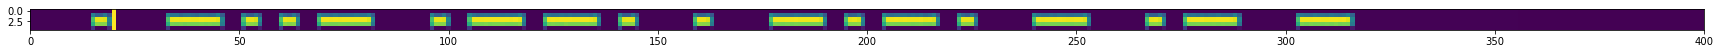

----------------------------------------------------------------------------------------
Prediction [22.919308]


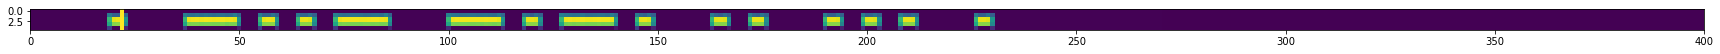

Correct 24.0


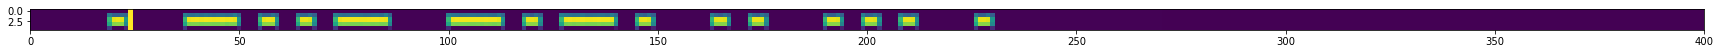

----------------------------------------------------------------------------------------
Prediction [42.602966]


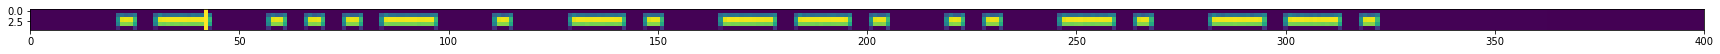

Correct 44.0


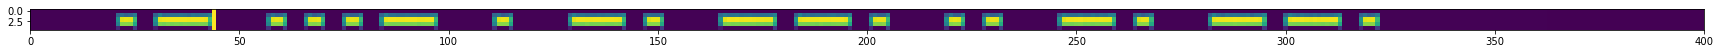

----------------------------------------------------------------------------------------
Prediction [36.464626]


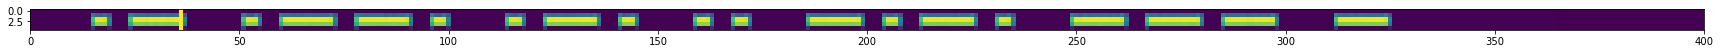

Correct 38.0


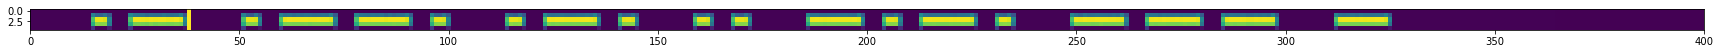

----------------------------------------------------------------------------------------
Prediction [36.910053]


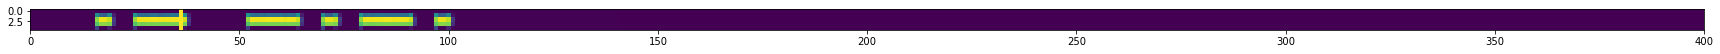

Correct 38.0


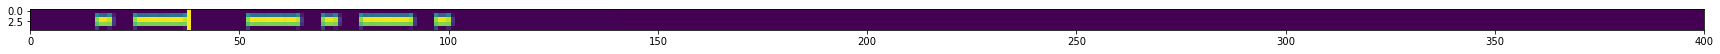

----------------------------------------------------------------------------------------
Prediction [55.098793]


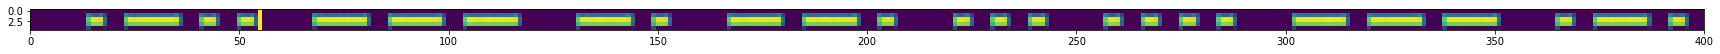

Correct 54.0


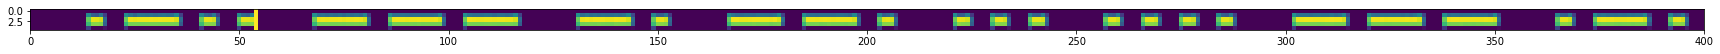

----------------------------------------------------------------------------------------
Prediction [19.143238]


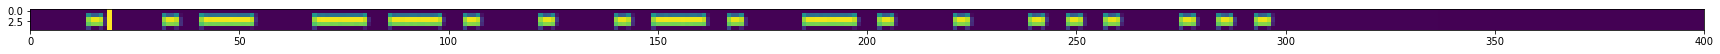

Correct 18.0


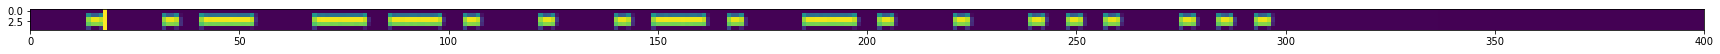

----------------------------------------------------------------------------------------
Prediction [42.70561]


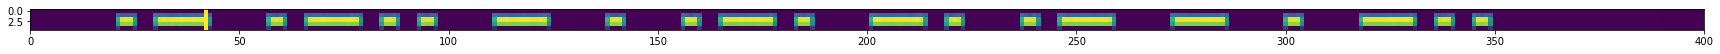

Correct 44.0


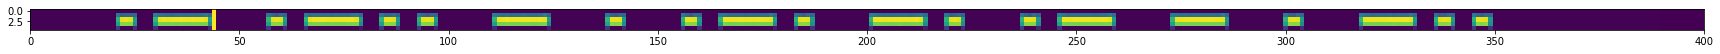

----------------------------------------------------------------------------------------
Prediction [33.941963]


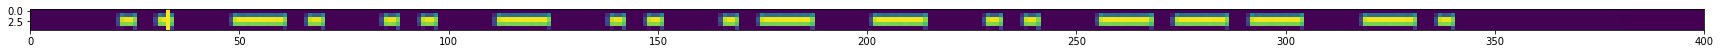

Correct 35.0


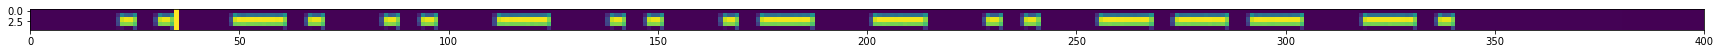

----------------------------------------------------------------------------------------
Prediction [56.040985]


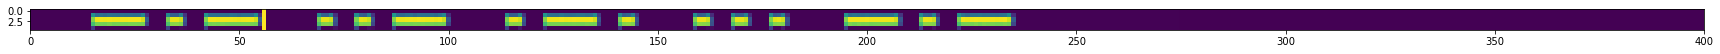

Correct 55.0


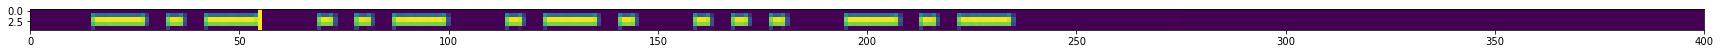

----------------------------------------------------------------------------------------
Prediction [45.972088]


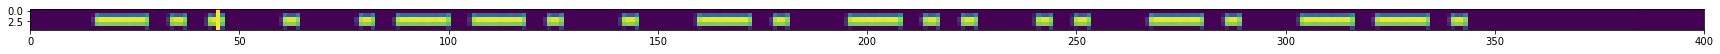

Correct 47.0


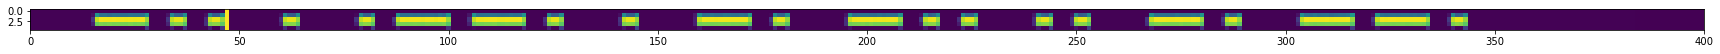

----------------------------------------------------------------------------------------
Prediction [16.576]


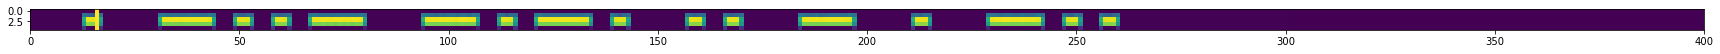

Correct 18.0


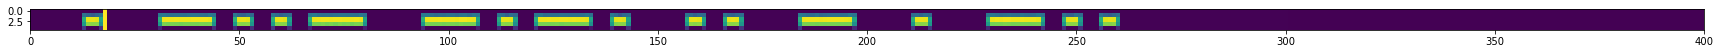

----------------------------------------------------------------------------------------
Prediction [29.71742]


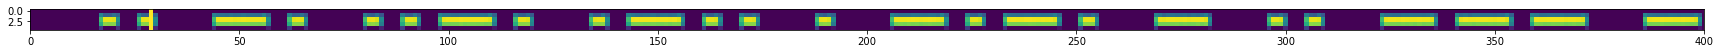

Correct 30.999999999999996


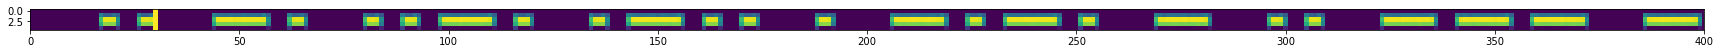

----------------------------------------------------------------------------------------
Prediction [37.919807]


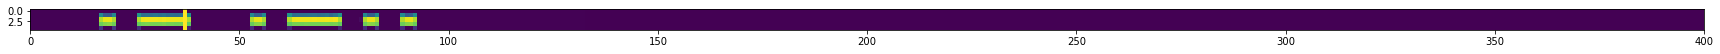

Correct 39.0


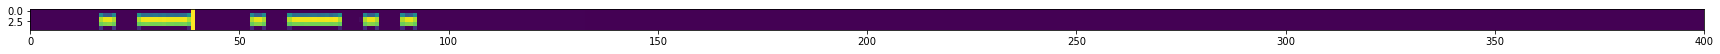

----------------------------------------------------------------------------------------
Prediction [55.8107]


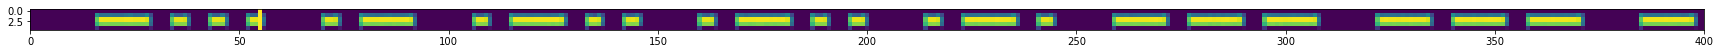

Correct 57.0


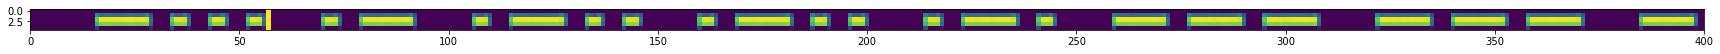

----------------------------------------------------------------------------------------
Prediction [20.847166]


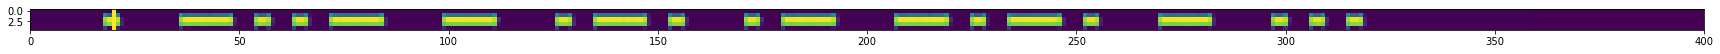

Correct 22.0


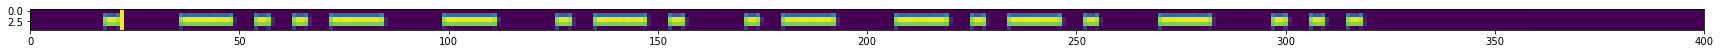

----------------------------------------------------------------------------------------
Prediction [27.51053]


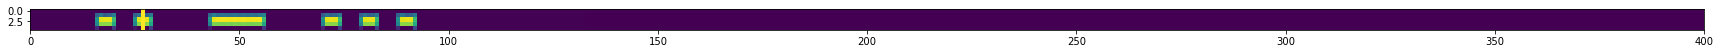

Correct 30.0


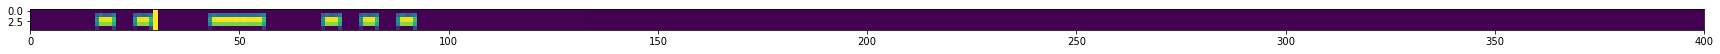

----------------------------------------------------------------------------------------
Prediction [53.684753]


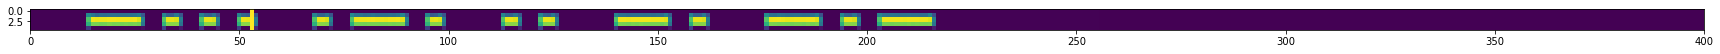

Correct 55.0


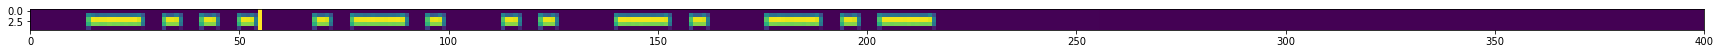

----------------------------------------------------------------------------------------
Prediction [29.78124]


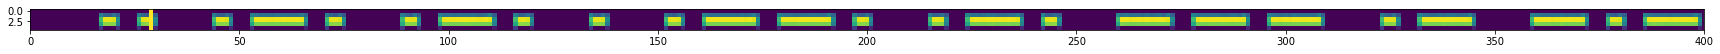

Correct 30.999999999999996


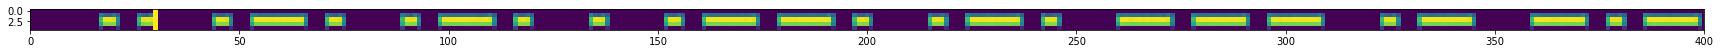

----------------------------------------------------------------------------------------
Prediction [69.41674]


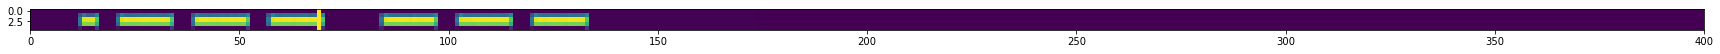

Correct 71.0


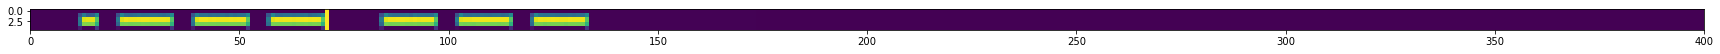

----------------------------------------------------------------------------------------
Prediction [24.457062]


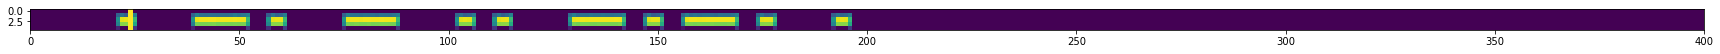

Correct 26.0


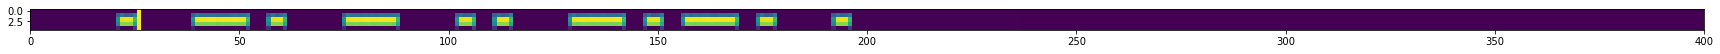

----------------------------------------------------------------------------------------
Prediction [60.99737]


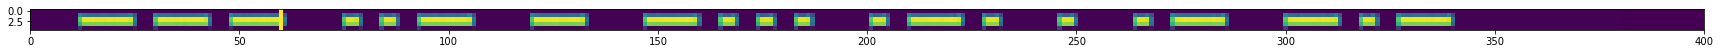

Correct 61.99999999999999


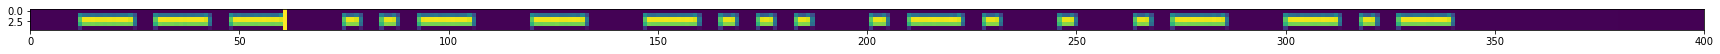

----------------------------------------------------------------------------------------
Prediction [36.94253]


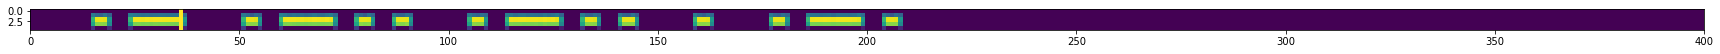

Correct 38.0


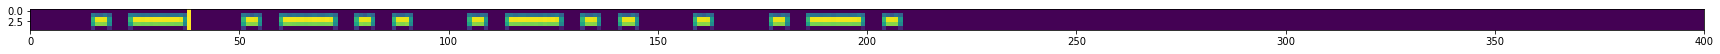

----------------------------------------------------------------------------------------
Prediction [53.1715]


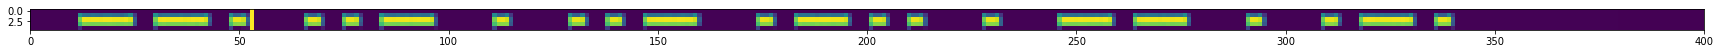

Correct 52.0


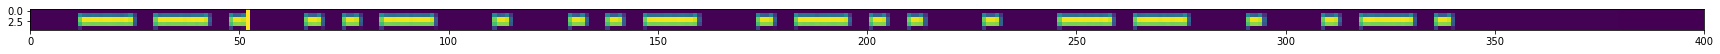

----------------------------------------------------------------------------------------
Prediction [36.74353]


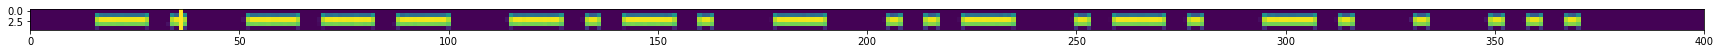

Correct 38.0


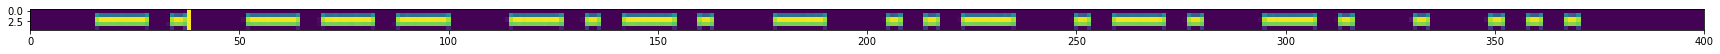

----------------------------------------------------------------------------------------
Prediction [20.883509]


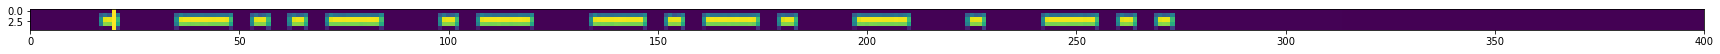

Correct 22.0


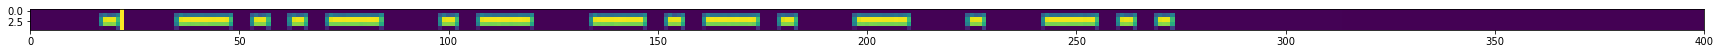

----------------------------------------------------------------------------------------
Prediction [42.4428]


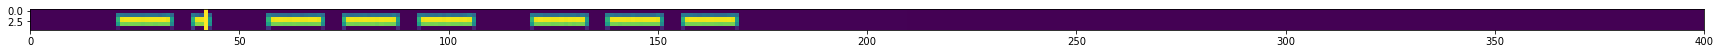

Correct 44.0


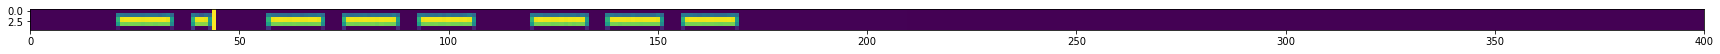

----------------------------------------------------------------------------------------


In [415]:

counter = 0   
for diff in deviating_predictions:

    counter += 1
    if counter > 30:
        break

    pred, correct, img = diff

    img_pred = img.copy()
    img_correct = img.copy()

    print('Prediction', pred)
    img_pred[:, int(pred)] = 1
    show_image(img_pred)

    print('Correct', correct)
    img_correct[:, int(correct)] = 1
    show_image(img_correct)

    print("----------------------------------------------------------------------------------------")


In [416]:
import matplotlib.backends.backend_pdf as mpt

def right_roll_image_by_n(img, roll_value_n):
    return np.roll(img, roll_value_n, axis=1)

def get_label_prediction(img, model, img_width): 
    x_right_rolled_exp_dim = np.expand_dims(img, axis=0)
    single_predict = model.predict(x_right_rolled_exp_dim)
    return single_predict[0] * img_width



def roll_and_display_img(img, indexer):

    image_right_rolled = right_roll_image_by_n(img, int(-10 + (indexer / 5)))

    label_prediction = get_label_prediction(image_right_rolled, model, IMAGE_TARGET_SIZE[1])

    # Draw vertical line
    image_right_rolled[:, int(label_prediction)] = 1

    fig = show_image(image_right_rolled)
    pdf.savefig( fig )


In [417]:
# %%capture 
# capture means suppress output

pdf = mpt.PdfPages("single_predictions_rolled_randomly.pdf")

single_image_batch, single_label_batch = test_batch_generator.__getitem__(0)

for i in range(len(single_image_batch)):
    roll_and_display_img(single_image_batch[i], i)
    
pdf.close()

ValueError: in user code:

    /home/nig/miniconda3/envs/newenv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /home/nig/miniconda3/envs/newenv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/nig/miniconda3/envs/newenv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/nig/miniconda3/envs/newenv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/nig/miniconda3/envs/newenv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/nig/miniconda3/envs/newenv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /home/nig/miniconda3/envs/newenv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /home/nig/miniconda3/envs/newenv/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/nig/miniconda3/envs/newenv/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:200 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_29 expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 5, 1400, 1) dtype=float32>]
